# ohsome API: Data Aggregation Endpoint

Via the ohsome API you have access to the OSM history on a global scale :). Our [documentation](https://docs.ohsome.org/ohsome-api/stable) provides you with the needed information to fire some requests against the API. More infomation about ohsome can be found [here](https://ohsome.org).

In the following we show you some examples how to grab aggregated statistics on the evolution of OSM using Python. 

### Import Python packages

In [1]:
# pandas for working with table structured data
import pandas as pd
import matplotlib.pyplot as plt

# json for handling with json responses
import json

# requests for http get/post requests
import requests
import plotly
import IPython

# plotly for generating interactive graphs
import chart_studio.plotly as py
import plotly.graph_objs as go

from IPython.display import *

plotly.offline.init_notebook_mode(connected=True)

### Define global constants

Let's get started and have a more detailed look at three areas in Germany: Heidelberg _(hd)_, Mannheim _(ma)_ and Ludwigshafen _(lu)_. 

In [2]:
OHSOME_API = "https://api.ohsome.org/v1"

# Define areas of interest
BBOX = {
    "hd": "8.6581,49.3836,8.7225,49.4363",
    "ma": "8.4514,49.4589,8.5158,49.5114",
    "lu": "8.3936,49.4448,8.4579,49.4974"
}

# Define time intervals: https://en.wikipedia.org/wiki/ISO_8601
TIME_MONTHLY = "2007-11-01/2018-11-01/P1M"
TIME_YEARLY = "2007-11-01/2018-11-01/P1Y"

### Declaring some helper functions¶

In [3]:
def elements(agg, **params):
    res = requests.get(OHSOME_API+"/elements"+agg, params)
    return res

First we request some metadata.

In [4]:
metadata = requests.get(OHSOME_API+"/metadata").json()

display(metadata)

{'attribution': {'url': 'https://ohsome.org/copyrights',
  'text': '© OpenStreetMap contributors'},
 'apiVersion': '1.6.0',
 'timeout': 600.0,
 'extractRegion': {'spatialExtent': {'type': 'Polygon',
   'coordinates': [[[-180.0, -90.0],
     [180.0, -90.0],
     [180.0, 90.0],
     [-180.0, 90.0],
     [-180.0, -90.0]]]},
  'temporalExtent': {'fromTimestamp': '2007-10-08T00:00:00Z',
   'toTimestamp': '2021-09-05T20:00Z'},
  'replicationSequenceNumber': 78733}}

Lossless information on the historical evolution of OSM is available from 8th of October 2007 to 19th of February 2019. This means that all properties of the original OSM data are maintained.

## Aggregation endpoint
The aggregation endpoint allows you to retrieve aggregated statistics for the OSM history data. You can filter by any OSM tag _(keys, values)_, define your area of interest _(bboxes)_ and choose any time interval _(time)_.

### Count buildings in Heidelberg over time

'https://api.ohsome.org/v1/elements/count?filter=building%3D%2A&bboxes=8.6581%2C49.3836%2C8.7225%2C49.4363&time=2007-11-01%2F2018-11-01%2FP1M'

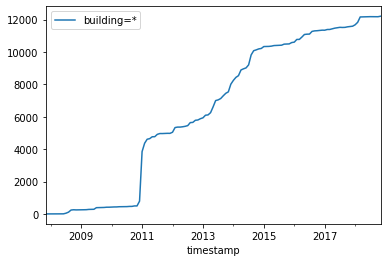

In [5]:
def count():
    filter = 'building=*'
    # sending get request to ohsome API
    res = elements("/count", filter=filter, bboxes=BBOX['hd'],
                   time=TIME_MONTHLY)
    display(res.url)
    body = res.json()
    # extracting data in json format and storing it in a dataframe
    df = pd.DataFrame(body['result'])
    df.timestamp = pd.to_datetime(df.timestamp)
    df.rename(columns={'value': filter}, inplace=True)
    df.set_index('timestamp', inplace=True)
    # plotting the result
    df.plot()
    plt.show()


count()

### Ratio between two OSM tag groups over time
The ohsome API also allows you two generate ratios between two different OSM tag groups. In this example we answer the question: What is the percentage of OSM buildings that include house numbers (are tagged with the OSM key _addr:housenumber_)? 

'https://api.ohsome.org/v1/elements/count/ratio?filter=building%3D%2A&filter2=building%3D%2A+and+addr%3Ahousenumber%3D%2A&bboxes=8.6581%2C49.3836%2C8.7225%2C49.4363&time=2007-11-01%2F2018-11-01%2FP1M'

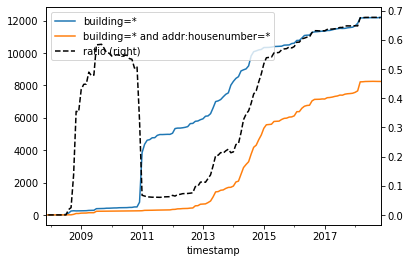

In [6]:
def ratio():
    filter = "building=*"
    filter2 = "building=* and addr:housenumber=*"
    # sending get request to ohsome API
    res = elements("/count/ratio", filter=filter, filter2=filter2,
                   bboxes=BBOX['hd'], time=TIME_MONTHLY)
    display(res.url)
    body = res.json()
    # extracting data in json format and storing it in a dataframe
    df = pd.DataFrame(body['ratioResult'])
    df.timestamp = pd.to_datetime(df.timestamp)
    df.set_index('timestamp', inplace=True)
    df.rename(columns={'value': filter, 'value2': filter2}, inplace=True)
    df = df.astype(float)
    # plotting the result
    df[filter].plot(legend=True)
    df[filter2].plot(legend=True)
    df.ratio.plot(style='k--', secondary_y=True, legend=True)
    plt.show()


ratio()

### Count over time grouped by bounding box
We are not only interested in the Heidelberg area but also in Mannheim and Ludwigshafen. Using the _groupBy/boundary_ resource allows you to get the OSM evolution for all areas with one single request.

'https://api.ohsome.org/v1/elements/count/groupBy/boundary?filter=building%3D%2A&bboxes=hd%3A8.6581%2C49.3836%2C8.7225%2C49.4363%7Cma%3A8.4514%2C49.4589%2C8.5158%2C49.5114%7Clu%3A8.3936%2C49.4448%2C8.4579%2C49.4974&time=2007-11-01%2F2018-11-01%2FP1Y'

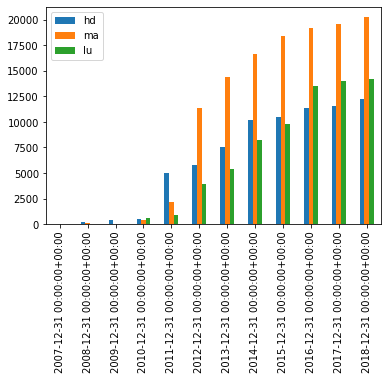

In [7]:
def groupBy():
    filter = "building=*"
    bboxes = '|'.join("{}:{}".format(k, v) for (k, v) in BBOX.items())
    # sending get request to ohsome API
    res = elements("/count/groupBy/boundary", filter=filter, bboxes=bboxes,
                   time=TIME_YEARLY)
    display(res.url)
    body = res.json()
    # extracting data in json format and storing it in a dataframe
    df = pd.DataFrame()
    for groupBy in body['groupByResult']:
        series = pd.Series(
            {row['timestamp']: row['value'] for row in groupBy['result']}
        )
        df[groupBy['groupByObject']] = series
    df.set_index(pd.to_datetime(df.index), inplace=True)
    # plotting the result
    df.resample('y').agg({'hd': 'sum', 'ma': 'sum', 'lu': 'sum'}).plot.bar()
    plt.show()


groupBy()

More examples will follow. Stay tuned!